# Código

In [1]:
import pandas as pd
import sklearn
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from lvm_read import read
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn import linear_model, decomposition, preprocessing,metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
from sklearn import metrics
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Params Download Data.
case_scheme = ["R", "L", "H"]
CH_numbers = 8
na = 17
# string="white_noise_"+str(case_num)+".lvm"
# d=read(join(getcwd(),f'Case_{case_scheme[0]}_(+25)/Case_{case_scheme[0]}_(+25)_{sensor_scheme}/',string))
# d[0]['Channel names'].pop()
# df=pd.DataFrame(d[0]['data'],columns=d[0]['Channel names'])
df_AR = []
for jj, case in enumerate(case_scheme):
    #for i in tqdm(range(1, 41), desc=f"Case {case}"):
    for i in range(1, 41):
        if i > 20:
            ij = i-20
            sensor_scheme = "2"
        else:
            ij=i
            sensor_scheme ="1" # Sensor Scheme Choosed

        string="white_noise_"+str(ij)+".lvm"
        try:
            #print(f"{case}_{sensor_scheme}_{ij}")
            d=read(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_{sensor_scheme}/',string))
            d[0]['Channel names'].pop()
            df=pd.DataFrame(d[0]['data'],columns=d[0]['Channel names'])         
            ARmodel1 = AutoReg(df[f"Ch1"],na).fit()
            ARmodel2 = AutoReg(df[f"Ch2"],na).fit()
            ARmodel3 = AutoReg(df[f"Ch3"],na).fit()
            ARmodel4 = AutoReg(df[f"Ch4"],na).fit()
            ARmodel5 = AutoReg(df[f"Ch5"],na).fit()
            ARmodel6 = AutoReg(df[f"Ch6"],na).fit()
            ARmodel7 = AutoReg(df[f"Ch7"],na).fit()
            ARmodel8 = AutoReg(df[f"Ch8"],na).fit()
            ARparams=np.concatenate([ARmodel1.params,ARmodel2.params,ARmodel3.params,ARmodel4.params,
                                     ARmodel5.params,ARmodel6.params,ARmodel7.params,ARmodel8.params,[jj+1]])
            df_AR.append(ARparams)
        except:
            continue
df_AR=np.array(df_AR)


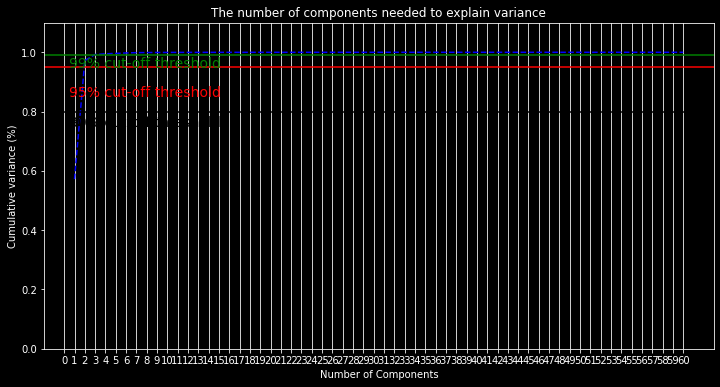

In [6]:
# PCA
pca = PCA().fit(df_AR[:,:-1])
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
exp_var = pca.explained_variance_ratio_
yi = np.cumsum(exp_var)
xi = np.arange(1, len(exp_var)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0,len(exp_var)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=14)
plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 0.95, '99% cut-off threshold', color = 'green', fontsize=14)
plt.axhline(y=0.80, color='black', linestyle='-')
plt.text(0.5, 0.75, '80% cut-off threshold', color = 'black', fontsize=14)

ax.grid(axis='x')
plt.show()

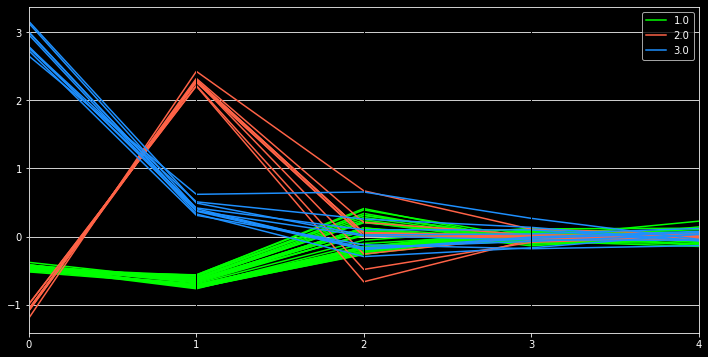

In [11]:
y_all = pd.DataFrame({'target':df_AR[:,-1]})
df_all_PCA = pd.DataFrame(PCA(n_components=5).fit_transform(df_AR[:,:-1]))#,columns=[f'{x} Component' for x in range(1,np.size(yi)+1)])
df_parallel = pd.concat([df_all_PCA,y_all],axis=1)
import plotly.express as px
fig = pd.plotting.parallel_coordinates(df_parallel,"target",color=["lime", "tomato","dodgerblue"]) # px.parallel_coordinates(df_parallel,)


<AxesSubplot:xlabel='variable', ylabel='value'>

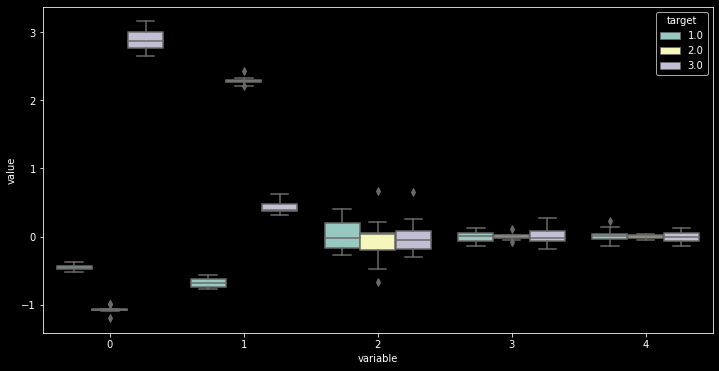

In [12]:
df_melted = df_parallel.melt(id_vars=['target'])
sns.boxplot(data = df_melted[df_melted['variable']<=10],x='variable',y='value',hue='target')

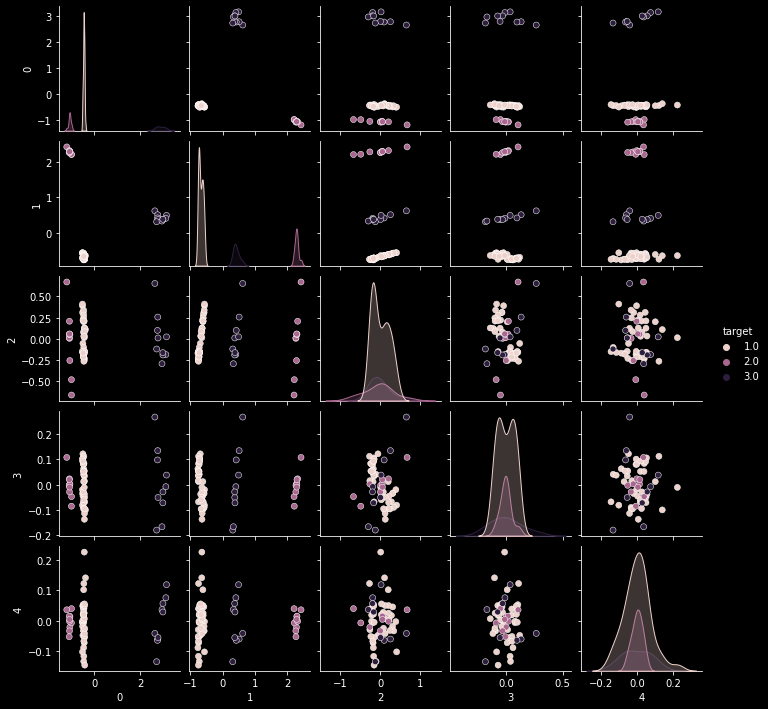

In [14]:
fig4=sns.pairplot(df_parallel,hue='target',height=2)

Text(0.5, 0.98, 'Dataset transformado por T-SNE e classificado pelo Label conhecido')

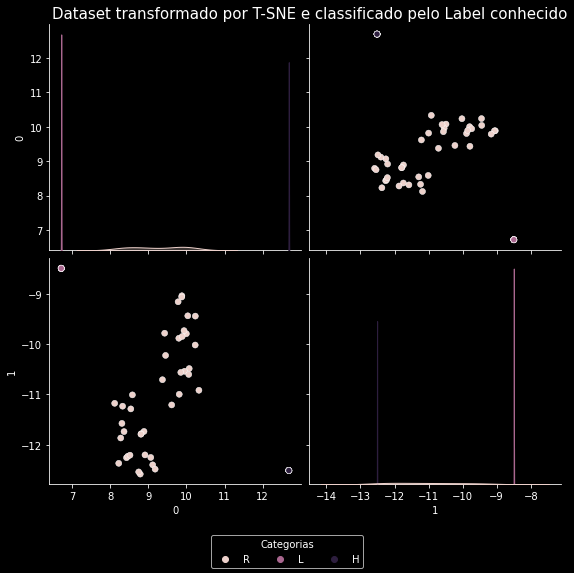

In [15]:
df_TSNE = pd.DataFrame(TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_parallel[df_parallel.columns[0:2]]))
df_TSNE = pd.concat([df_TSNE,df_parallel['target']],axis=1)
fig5=sns.pairplot(df_TSNE,hue='target',height=4)
fig5._legend.remove()
handles = fig5._legend_data.values()
labels = case_scheme
fig5.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig5.fig.subplots_adjust(top=0.95, bottom=0.15)
fig5.fig.suptitle('Dataset transformado por T-SNE e classificado pelo Label conhecido',fontsize=15)